In [26]:
import numpy as np 
import pandas as pd 
import os
import cv2 as cv
import matplotlib.pyplot as plt
from keras.applications import vgg16
from keras.models import Model,load_model
import keras
from keras.layers import Input, Conv2D, Conv2DTranspose,AveragePooling2D, MaxPooling2D,UpSampling2D,LeakyReLU, concatenate, Dropout,BatchNormalization,Activation
from keras.callbacks import EarlyStopping,ModelCheckpoint
import pandas as pd
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from numpy.random import seed
#seed(123)
import tensorflow as tf


In [42]:
input_shape=(500,500)
vgg16=tf.keras.applications.vgg16.VGG16(
    include_top=False,
    input_shape=(500,500,3),
    weights='imagenet',
    input_tensor=None,

    pooling=None,
    classifier_activation='softmax'
)

In [43]:
def ModelEnhancer():
    
    
    VGG16 = vgg16
    last_layer = VGG16.output
    
    set_trainable = False
    for layer in VGG16.layers:
        if layer.name in ['block1_conv1']:
            set_trainable = True
        if layer.name in ['block1_pool','block2_pool','block3_pool','block4_pool','block5_pool']:
            layer.trainable = False
            
    model_ = Conv2DTranspose(256,(3,3),strides=(2, 2))(last_layer)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)    
    
    concat_1 = concatenate([model_,VGG16.get_layer("block5_conv3").output])
    
    model_ = Conv2D(512,(3,3),strides=(1, 1),padding='same')(concat_1)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2DTranspose(512,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_) 
    
    concat_2 = concatenate([model_,VGG16.get_layer("block4_conv3").output])
    
    model_ = Conv2D(512,(3,3),strides=(1, 1),padding='same')(concat_2)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2DTranspose(512,(3,3),strides=(2, 2))(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_) 
    
    concat_3 = concatenate([model_,VGG16.get_layer("block3_conv3").output])
    
    model_ = Conv2D(256,(3,3),strides=(1, 1),padding='same')(concat_3)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2DTranspose(256,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_) 
    
    concat_4 = concatenate([model_,VGG16.get_layer("block2_conv2").output])
    
    model_ = Conv2D(128,(3,3),strides=(1, 1),padding='same')(concat_4)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2DTranspose(128,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_) 
    
    concat_5 = concatenate([model_,VGG16.get_layer("block1_conv2").output])
    
    model_ = Conv2D(64,(3,3),strides=(1, 1),padding='same')(concat_5)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)
    
    '''model_ = Conv2D(32,(3,3),strides=(1, 1),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)'''
    
    model_ = Conv2D(3,(3,3),strides=(1, 1),padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Model(VGG16.input,model_)
    
    return model_

In [44]:
Model_ = ModelEnhancer()
Model_.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 500, 500, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 500, 500, 64  1792        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 500, 500, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

                                                                                                  
 batch_normalization_38 (BatchN  (None, 62, 62, 512)  2048       ['leaky_re_lu_38[0][0]']         
 ormalization)                                                                                    
                                                                                                  
 conv2d_transpose_21 (Conv2DTra  (None, 125, 125, 51  2359808    ['batch_normalization_38[0][0]'] 
 nspose)                        2)                                                                
                                                                                                  
 leaky_re_lu_39 (LeakyReLU)     (None, 125, 125, 51  0           ['conv2d_transpose_21[0][0]']    
                                2)                                                                
                                                                                                  
 batch_nor

In [45]:
Model_.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [46]:
checkpointer = ModelCheckpoint('model_TL_UNET.h5', verbose=1,mode='auto', monitor='loss',save_best_only=True)

In [47]:
InputPath='data/'
def ExtractData(InputPath):
    SourceImg = sorted(os.listdir(InputPath+'images'))
    TargetImg = sorted(os.listdir(InputPath+'masks'))
    X_=[]
    y_=[]
    count=0
    for i in range(len(SourceImg)):
        if count<31:
            count=count+1
            img_1 = cv.imread(InputPath + 'images/'+SourceImg[i])
            img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
            img_1 = cv.resize(img_1,input_shape)
            X_.append(img_1)
            img_2 = cv.imread(InputPath + 'masks/'+TargetImg[i])
            img_2 = cv.cvtColor(img_2, cv.COLOR_BGR2RGB)
            img_2 = cv.resize(img_2,input_shape)
            y_.append(img_2)
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_,y_

In [48]:
X_,y_ = ExtractData(InputPath)
print(y_.shape)

(31, 500, 500, 3)


In [ ]:
def GenerateInputs(X,y):
    for i in range(len(X)):
        X_input = X[i].reshape(1,500,500,3)
        y_input = y[i].reshape(1,500,500,3)
        yield (X_input,y_input)
Model_.fit_generator(GenerateInputs(X_,y_),epochs=55,verbose=1,callbacks=[checkpointer],
                     steps_per_epoch=5,shuffle=True)

In [49]:
TransferLearningModel = load_model('model_TL_UNET.h5')
img_x = cv.imread(InputPath + "images/0.png")
img_x = cv.cvtColor(img_x, cv.COLOR_BGR2RGB)
img_x = cv.resize(img_x,(500,500))
img_x = img_x.reshape(1,500,500,3)

1/1 [==============================] - 4s 4s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


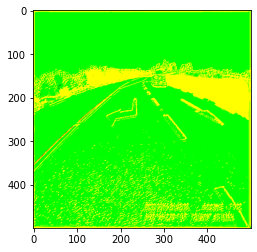

In [50]:
prediction = TransferLearningModel.predict(img_x)
pred = prediction.reshape(500,500,3)
pred_ = cv.resize(pred,(500,500))
plt.imshow(pred_)